<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

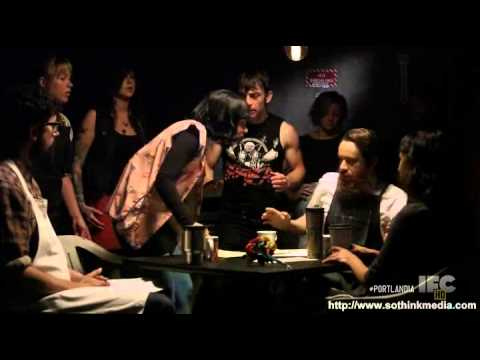

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\Zach\\repos\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [65]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
print(shops.shape)
shops.head()

(7616, 3)


,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [66]:
# MY CODE STARTS HERE

# first thing I wanna do is clean the data; lets start with star_rating
print(type(int('2')), int('2'))
print(shops['star_rating'].value_counts(dropna=False))

<class 'int'> 2
 5.0 star rating     3780
 4.0 star rating     2360
 3.0 star rating      738
 2.0 star rating      460
 1.0 star rating      278
Name: star_rating, dtype: int64


In [67]:
# yeah that's what I thought, let's change that to an integer column
def clean_star_ratings(str_in):
    # print(str_in, str_in[1])
    str_in = str_in[1]
    str_in = int(str_in)
    return str_in
shops['star_rating'] = shops['star_rating'].apply(clean_star_ratings)
print(shops.dtypes)
shops.head()

coffee_shop_name    object
full_review_text    object
star_rating          int64
dtype: object


,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4


In [68]:
# The next thing I want to clean up is the full_review_text
# it seems like it's a combination of date, some metadata maybe
# from the app used to post the review, and then the review itself.
# I want to see the review text in a bit more detail first.

shops['full_review_text'][12]

" 11/17/2016 1 check-in Listed in 2016 - The Third Time is a Charm! The Factory has A+ decor and a very innovative interactionless (tablet) ordering system. This allows you to look up what to get without feeling pressured by a barista staring at you waiting for you to order. The eclectic selection of tables, couches, and swings (?!) inside with a small kiddy corner appeal to many different types of tastes. This is seriously a cool place to hang out.  However, when it comes to the coffee and food, it's rather not cheap. The waffles range from $4-$8, and coffee is between $3.50 and $5. The quality of the coffee is not yet up to par with other coffee mainstays in Austin, so I would probably not choose to come here just for coffee. However, it is a CUTE date place and I know that M and I will probably come back to chat, people-watch, or read books. "

In [69]:
# First I want to grab those timestamps, just in case
def grab_timestamp(text):
    text = text.strip()
    match = re.search('^[0-9]+[/][0-9]+[/][0-9]+', text)
    text = match.group()
    # Turn it into pandas datetimes
    text = pd.to_datetime(text, format='%m/%d/%Y')
    return text

sample = grab_timestamp(' 11/17/2016')
print(type(sample), sample)

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2016-11-17 00:00:00


In [70]:
shops['timestamp'] = shops['full_review_text'].apply(grab_timestamp)

shops.head()

,coffee_shop_name,full_review_text,star_rating,timestamp
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03


In [71]:
# Yeah, so there's a few things I see right off the bat:
# - starts with a space
# - there's a timestamp in front of every one
# - some have a "See all photos from" thing at the end of them
# - some have a "(n) check-in(s)" thing after the timestamp
# - some have a "Listed in ______" after the timestamp

# Lets make a function to tokenize this
import re

def tokenize(text):
    ''' cleanup and tokenizing function '''
    # remove whitespace
    text = text.strip()
    # remove timestamps
    text = re.sub('^[0-9]+[/][0-9]+[/][0-9]+ ', '', text)
    # remove check-ins
    text = re.sub('^[0-9]+ check-in[s]* ', '', text)
    # remove "Listed in"
    text
    # remove "see photos" endings
    text = re.sub(' See all photos from (.*)$', '', text)
    # leave only letters and numbers
    text = re.sub('[^a-zA-Z 0-9]', '', text)
    # set everything to lowercase and split into tokens
    text = text.lower().split()
    
    return text
    
sample = ' 11/10/2016 3 check-ins This place has been shown on my social media for days so i finally visited! See all photos from Sarah L. for The Factory - Cafe With a Soul '

print(tokenize(sample))

['this', 'place', 'has', 'been', 'shown', 'on', 'my', 'social', 'media', 'for', 'days', 'so', 'i', 'finally', 'visited']


In [72]:
# now to apply it to the full_review_text column.
# I'm gonna put the tokens into a new column as to not lose the
# original text.

shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [73]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,timestamp,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,"[love, love, loved, the, atmosphere, every, co..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,"[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,"[listed, in, brunch, spots, i, loved, the, ecl..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,"[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,"[they, are, located, within, the, northcross, ..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [74]:
# I'm gonna do token counts and then maybe filter them through spacy
# and then do some graphs idk
from collections import Counter

counts = Counter()

shops['tokens'].apply(lambda x: counts.update(x))

counts.most_common(10)

[('the', 34760),
 ('and', 26644),
 ('a', 22701),
 ('i', 20232),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10260),
 ('was', 9707),
 ('in', 9546)]

In [77]:
# Lets see if I can use spacy to filter these cause
# this doesn't tell me anything.

# First, let me grab spacy's list of stop words
import spacy
nlp = spacy.load('en_core_web_lg')
STOP_WORDS = nlp.Defaults.stop_words

def filter_tokens(tokens):
    new_tokens = [x for x in tokens if x not in STOP_WORDS]
    return new_tokens

sample = shops['tokens'][0].copy()

print(filter_tokens(sample))

['love', 'love', 'loved', 'atmosphere', 'corner', 'coffee', 'shop', 'style', 'swings', 'ordered', 'matcha', 'latte', 'muy', 'fantastico', 'ordering', 'getting', 'drink', 'pretty', 'streamlined', 'ordered', 'ipad', 'included', 'beverage', 'selections', 'ranged', 'coffee', 'wine', 'desired', 'level', 'sweetness', 'checkout', 'system', 'got', 'latte', 'minutes', 'hoping', 'typical', 'heart', 'feather', 'latte', 'found', 'listing', 'possibilities', 'art', 'ideas']


In [78]:
shops['tokens'] = shops['tokens'].apply(filter_tokens)

shops.head()

,coffee_shop_name,full_review_text,star_rating,timestamp,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,"[love, love, loved, atmosphere, corner, coffee..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,"[listed, date, night, austin, ambiance, austin..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,"[listed, brunch, spots, loved, eclectic, homey..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,"[cool, decor, good, drinks, nice, seating, ove..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,"[located, northcross, mall, shopping, center, ..."


In [90]:
# Okay, the tokens are filtered, lets run the counter again
counts = Counter()

shops['tokens'].apply(lambda x: counts.update(x))

# save as a dataframe for later
counts_df = pd.DataFrame(counts.most_common())
counts_df.columns = ['token', 'count']
counts_sum = sum(counts_df['count'])
counts_df['percent'] = counts_df['count'] / counts_sum

print(counts_df.head())
print(counts.most_common(10))

    token  count   percent
0  coffee  10260  0.028400
1   place   5426  0.015019
2    good   3973  0.010997
3   great   3919  0.010848
4    like   3088  0.008548
[('coffee', 10260), ('place', 5426), ('good', 3973), ('great', 3919), ('like', 3088), ('austin', 2248), ('love', 1935), ('time', 1884), ('im', 1861), ('food', 1836)]


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [91]:
good_shops = shops[shops['star_rating']>3]
bad_shops = shops[shops['star_rating']<=3]

good_shops.head()

,coffee_shop_name,full_review_text,star_rating,timestamp,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,2016-11-25,"[love, love, loved, atmosphere, corner, coffee..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,2016-12-02,"[listed, date, night, austin, ambiance, austin..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,2016-11-30,"[listed, brunch, spots, loved, eclectic, homey..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,2016-12-03,"[located, northcross, mall, shopping, center, ..."
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4,2016-11-20,"[cute, cafe, think, moment, stepped, wasnt, di..."


In [92]:
bad_shops.head()

,coffee_shop_name,full_review_text,star_rating,timestamp,tokens
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,2016-11-25,"[cool, decor, good, drinks, nice, seating, ove..."
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3,2016-10-25,"[ok, lets, try, approach, pros, music, seating..."
11,The Factory - Cafe With a Soul,"11/20/2016 The store has A+ decoration, but h...",3,2016-11-20,"[store, decoration, honestly, coffee, good, co..."
12,The Factory - Cafe With a Soul,11/17/2016 1 check-in Listed in 2016 - The Th...,3,2016-11-17,"[listed, 2016, time, charm, factory, decor, in..."
25,The Factory - Cafe With a Soul,"12/2/2016 Okay, so after visiting my friends ...",1,2016-12-02,"[okay, visiting, friends, la, trying, mint, mo..."


In [119]:
# get the counts
good_counts = Counter()
bad_counts = Counter()

good_shops['tokens'].apply(lambda x: good_counts.update(x))
bad_shops['tokens'].apply(lambda x: bad_counts.update(x))

# organize into dataframes
good_counts_df = pd.DataFrame(good_counts.most_common())
bad_counts_df = pd.DataFrame(bad_counts.most_common())

# column fixing
good_counts_df.columns = ['token', 'count']
bad_counts_df.columns = ['token', 'count']

# get the percentage values for the counts
good_counts_sum = sum(good_counts_df['count'])
bad_counts_sum = sum(bad_counts_df['count'])

good_counts_df['percent'] = good_counts_df['count'] / good_counts_sum
bad_counts_df['percent'] = bad_counts_df['count'] / bad_counts_sum

shop_diffs = []
for token in counts_df['token']:
    goodcount = good_counts_df.loc[good_counts_df['token'] == token]['count']
    if goodcount.empty:
        goodcount = 0
    else:
        goodcount = goodcount.to_list()[0]
    badcount = bad_counts_df.loc[bad_counts_df['token'] == token]['count']
    if badcount.empty:
        badcount = 0
    else:
        badcount = badcount.to_list()[0]
    goodperc = good_counts_df.loc[good_counts_df['token']== token]['percent']
    if goodperc.empty:
        goodperc = 0
    else:
        goodperc = goodperc.to_list()[0]
    badperc = bad_counts_df.loc[bad_counts_df['token']== token]['percent']
    if badperc.empty:
        badperc = 0
    else:
        badperc = badperc.to_list()[0]
    shop_diffs.append((token, goodcount - badcount, goodperc - badperc))
    
print(shop_diffs[:10])

[('coffee', 6048, 0.002747114805689295), ('place', 3202, 0.0014809871347387094), ('good', 2219, 7.821037172847482e-05), ('great', 2987, 0.00647364779548465), ('like', 1336, -0.0030543537198471256), ('austin', 1682, 0.0034618236721620176), ('love', 1515, 0.003518306106120797), ('time', 928, -0.0009586727817834356), ('im', 971, -0.0005115728349795708), ('food', 868, -0.0012256125693466012)]


In [120]:
shop_diffs_df = pd.DataFrame(shop_diffs)

shop_diffs_df.columns = ['token','count_difference','rel_freq_diff']

shop_diffs_df = shop_diffs_df.sort_values(by='rel_freq_diff', ascending=False)

shop_diffs_df.head(10)

,token,count_difference,rel_freq_diff
3,great,2987,0.006474
18,delicious,1226,0.003577
6,love,1515,0.003518
5,austin,1682,0.003462
24,best,1102,0.003065
0,coffee,6048,0.002747
12,friendly,1265,0.002745
47,amazing,732,0.002168
64,perfect,656,0.001960
54,favorite,671,0.001915


In [121]:
shop_diffs_df.tail(10)

,token,count_difference,rel_freq_diff
109,wasnt,91,-0.001548
136,said,49,-0.001590
179,minutes,-3,-0.001597
38,ordered,293,-0.001845
52,didnt,200,-0.001927
37,order,273,-0.002023
16,dont,555,-0.002027
195,asked,-74,-0.002064
19,service,480,-0.002258
4,like,1336,-0.003054


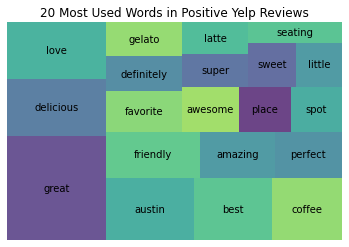

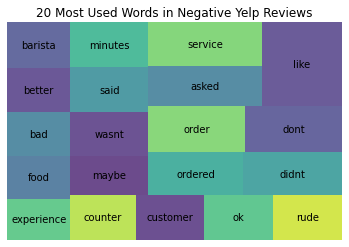

In [123]:
# some vizualizations
import squarify
import matplotlib.pyplot as plt
%matplotlib inline

top_10 = shop_diffs_df.head(20).copy()
bottom_10 = shop_diffs_df.tail(20).copy()

# top 20 plot (ignore the name, I changed it after)
squarify.plot(sizes=top_10['rel_freq_diff'], label=top_10['token'], alpha=.8)
plt.title('20 Most Used Words in Positive Yelp Reviews')
plt.axis('off')
plt.show()

squarify.plot(sizes=bottom_10['rel_freq_diff'], label=bottom_10['token'], alpha=.8)
plt.title('20 Most Used Words in Negative Yelp Reviews')
plt.axis('off')
plt.show()


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

